In [1]:
import tensorflow as tf 
from tensorflow import keras    
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import read_signal as rs
import tqdm

2024-01-14 16:57:07.692273: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 16:57:07.740763: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 16:57:07.740798: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 16:57:07.740831: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 16:57:07.749846: I tensorflow/core/platform/cpu_feature_g

Extracting EDF parameters from /home/nima/BraiNeoCare/Datasets/zenodo_eeg/eeg8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
[] []


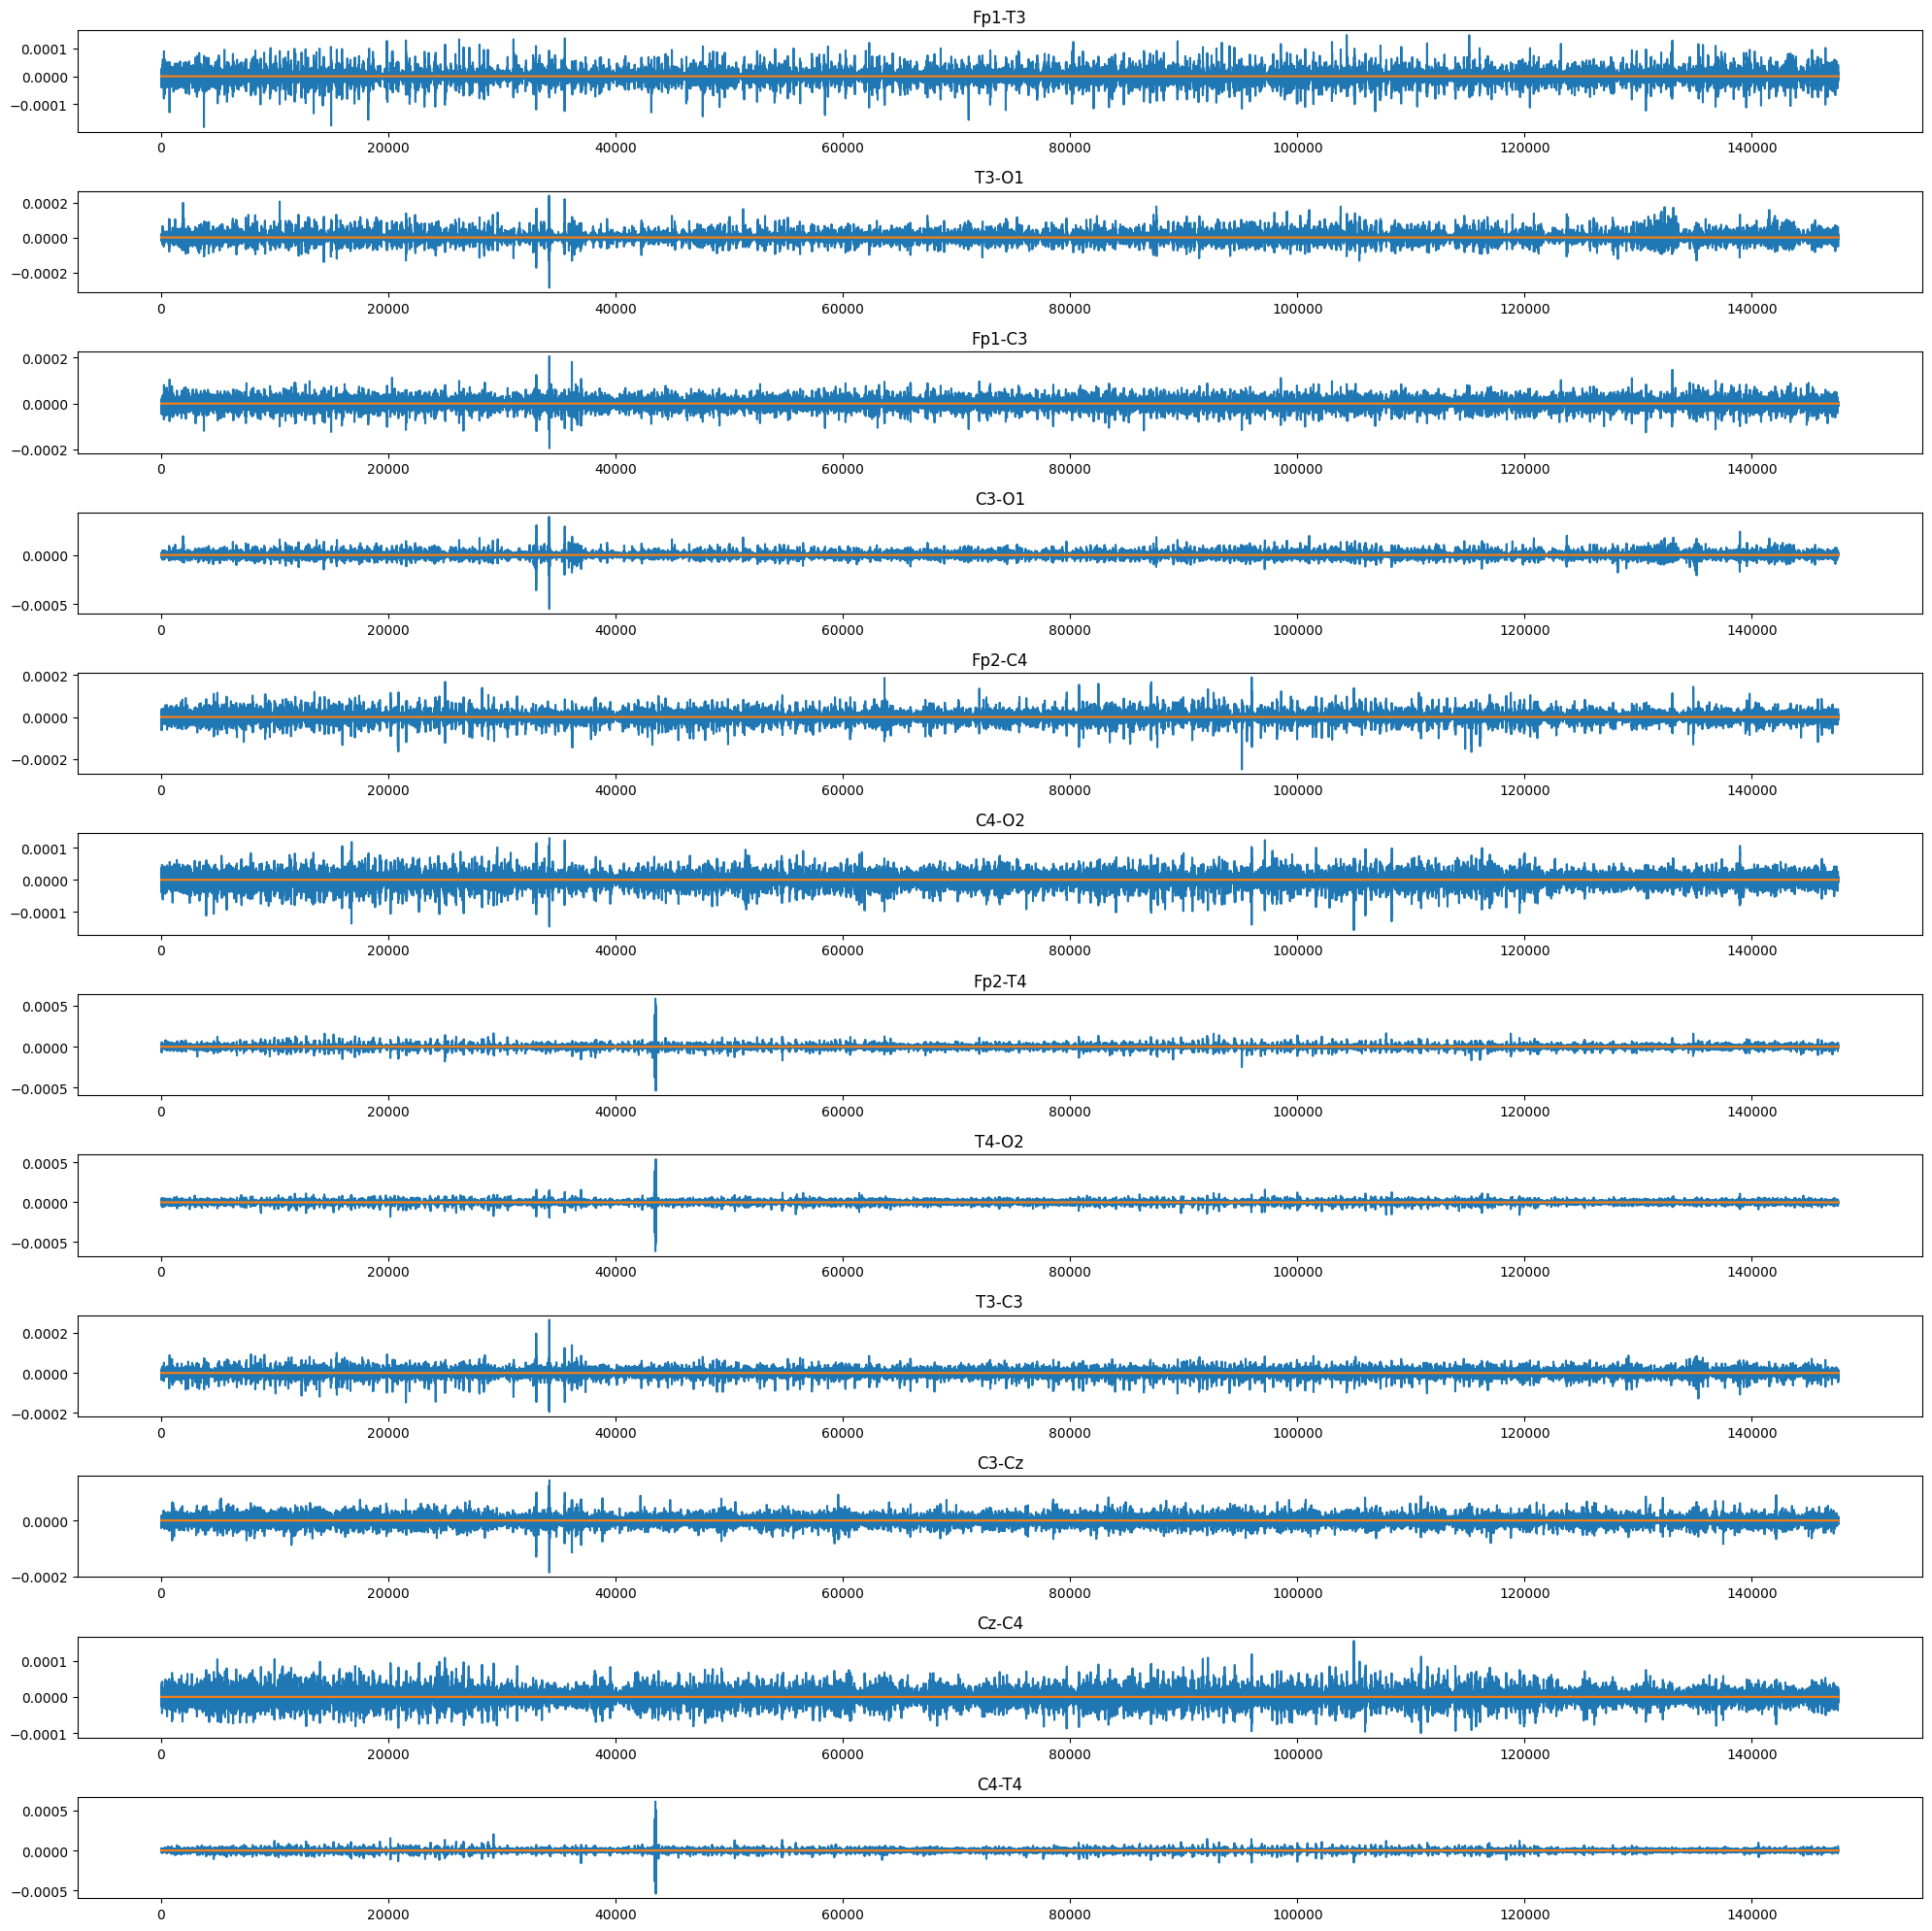

In [54]:
EEG,labels=rs.read_file("../BraiNeoCare/Datasets/zenodo_eeg/eeg8.edf",8)

In [3]:
model = keras.models.load_model("../BraiNeoCare/GAT_model_1/cp_0198.ckpt/")
model.layers[-1].activation = None

2024-01-14 17:00:37.155134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14827 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-01-14 17:00:37.155870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 503 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [4]:
mean=np.load("mean.npy")
std=np.load("std.npy")

grad_model = keras.Model(model.inputs,[model.get_layer("gat_layer_5").output,model.output])

def PreprocesSignal(signal):
    signal=(signal-mean)/std
    signal=np.expand_dims(signal,axis=-1)
    signal=np.expand_dims(signal,axis=0)
    return signal

def GradCAM(signal,model=grad_model):
    
    with tf.GradientTape() as tape:
        GAT_outputs, predictions = grad_model(signal)
        Class=predictions[:,0]

    grads = tape.gradient(Class, GAT_outputs)

    heatmap = GAT_outputs[0] *  tf.reduce_mean(grads, axis=(0,1,2))

    heatmap = tf.nn.relu(heatmap)/tf.reduce_max(heatmap)

    return heatmap.numpy(),tf.nn.sigmoid(predictions[0][0]).numpy()

In [55]:
def plot_explainable_signal():

    l, u = 0, 384
    length=EEG.shape[1]
    hmap=np.empty((12,length))
    predicted_class=[]
    x1=PreprocesSignal(EEG)
    
    for r in tqdm.tqdm(range(0,length-384,384),desc="processed GRAD-CAM"):
        h,p=GradCAM(x1[:,:,l:u,:])
        resized_heatmap = cv.resize(h, (384,12), interpolation=cv.INTER_LINEAR)
        hmap[:,l:u]=resized_heatmap
        predicted_class.append(1 if p>=0.5 else 0)
        l+=384
        u+=384 

    return hmap,predicted_class

hmap,prediction=plot_explainable_signal()
prediction=np.array([prediction])
prediction=np.repeat(prediction,384,axis=1)

processed GRAD-CAM:   0%|          | 0/384 [00:00<?, ?it/s]

processed GRAD-CAM: 100%|██████████| 384/384 [00:16<00:00, 23.09it/s]


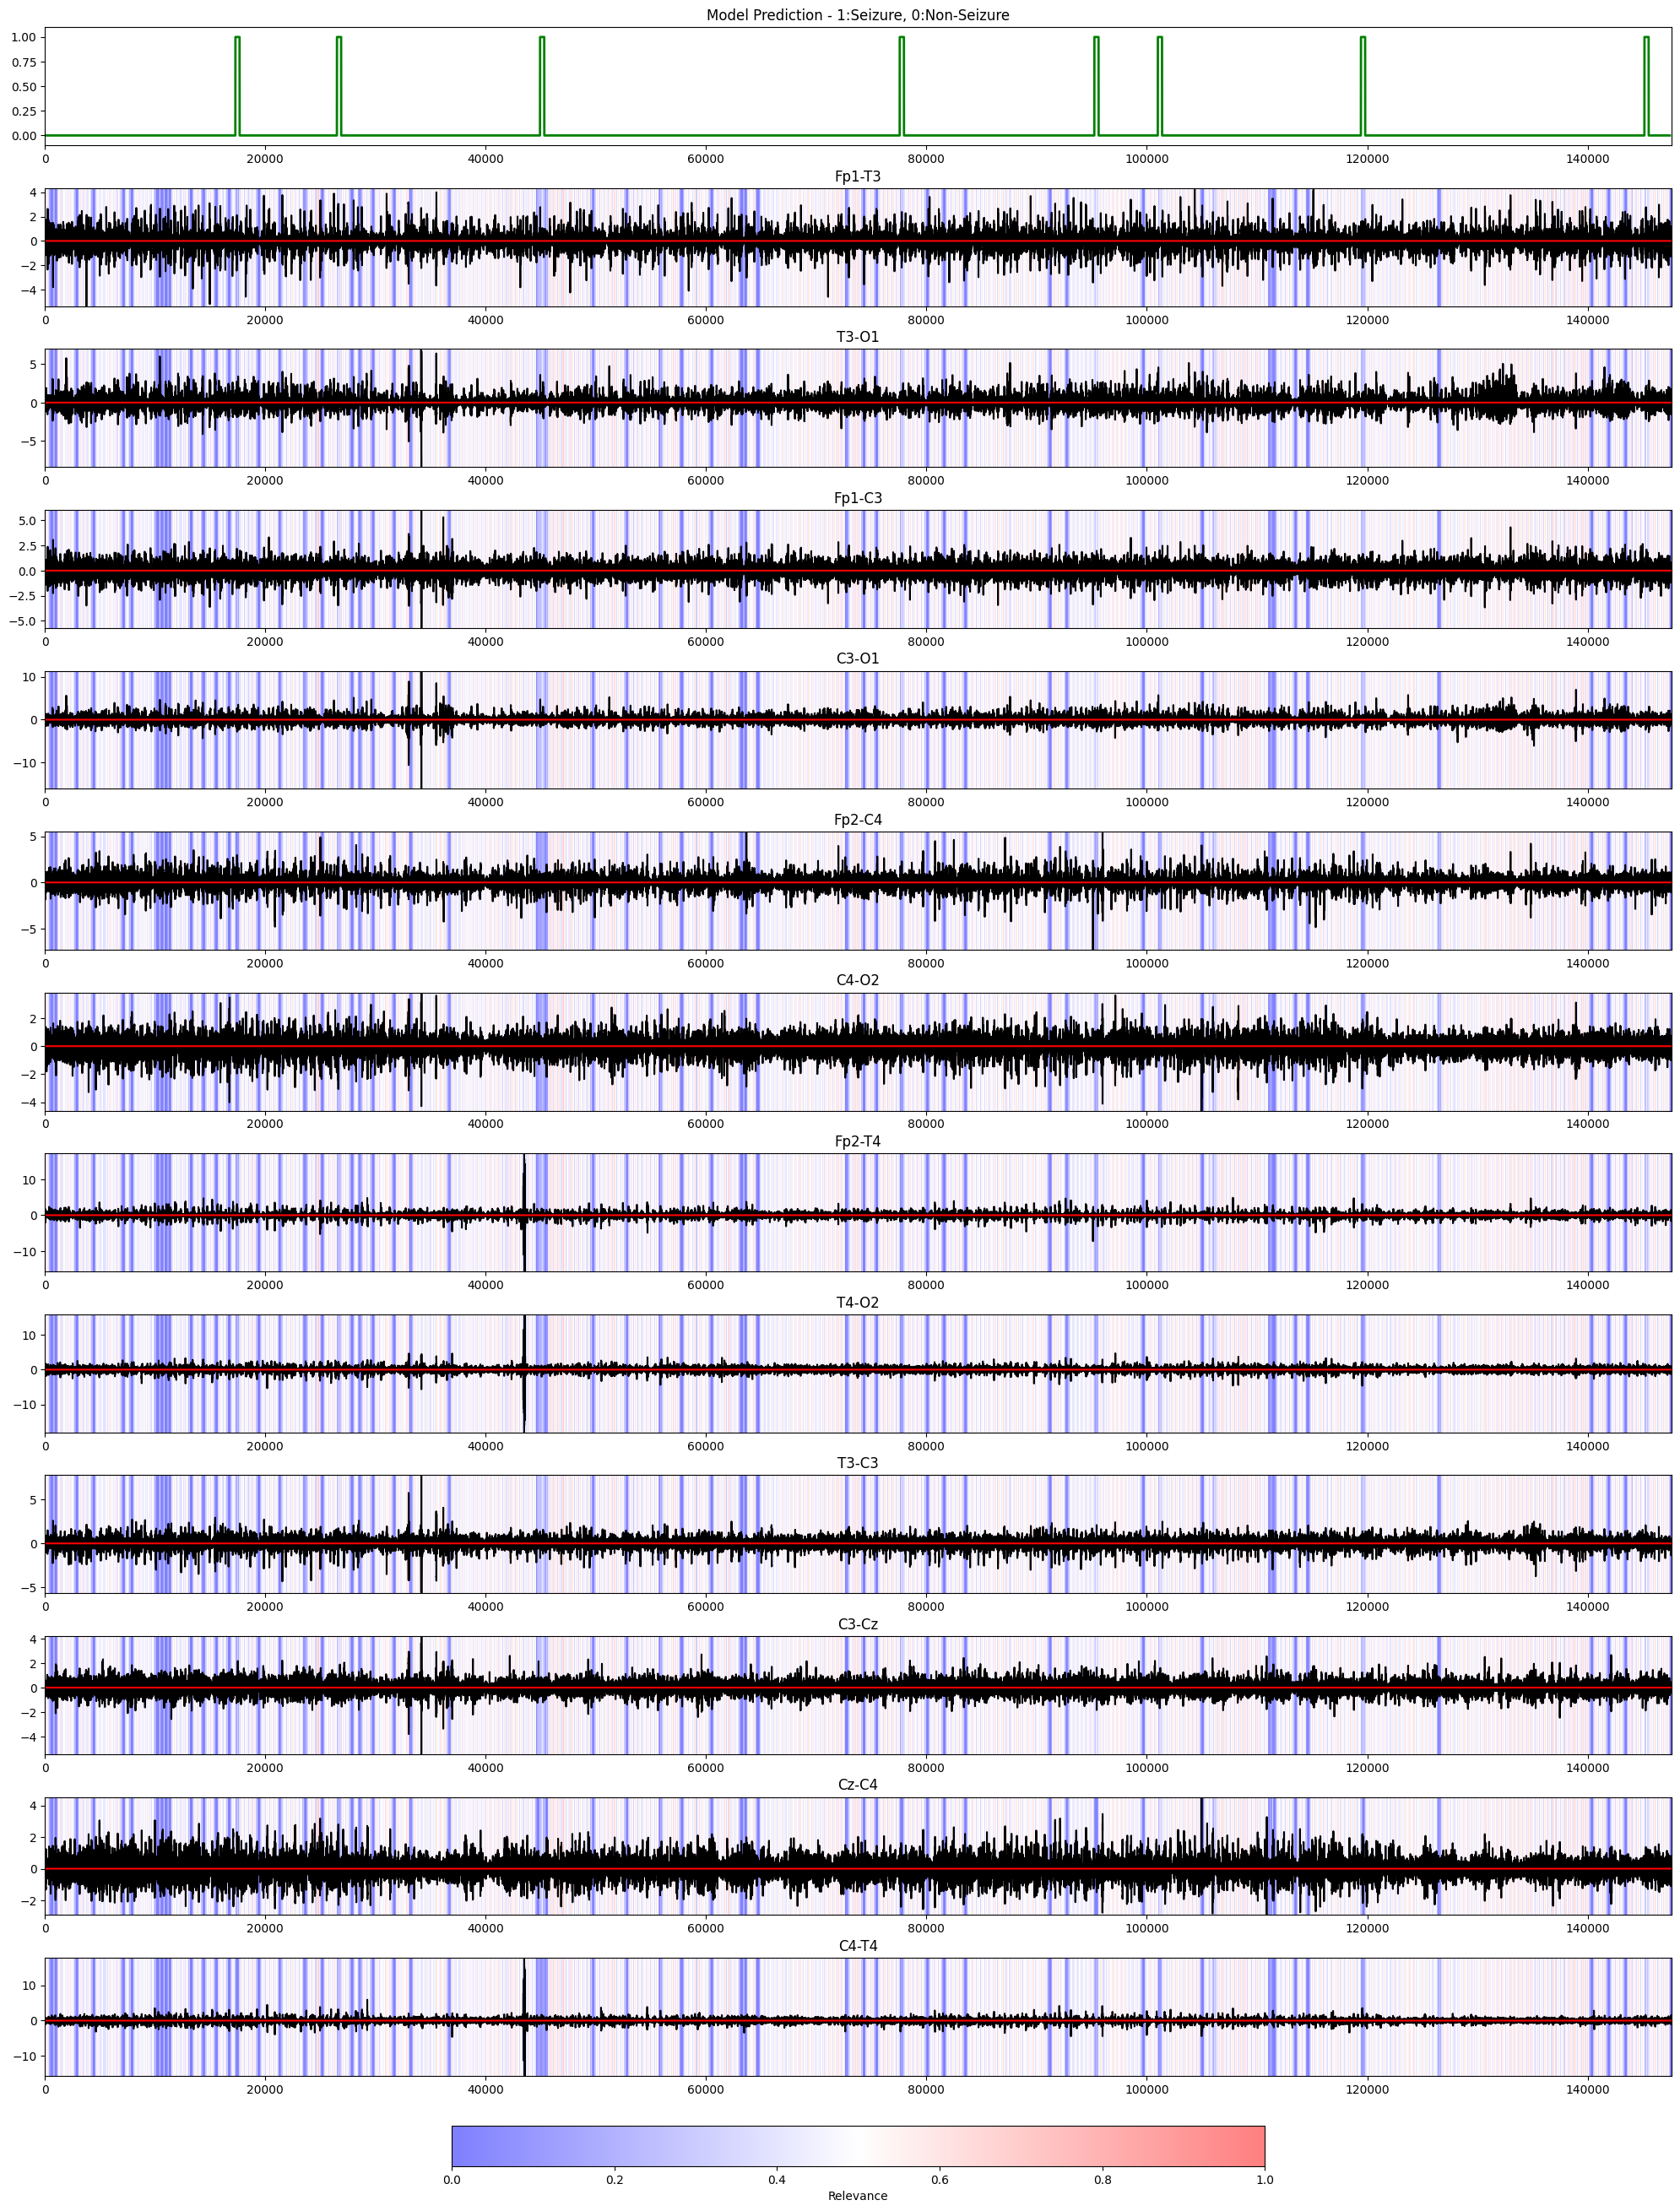

In [56]:
channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
fig,ax=plt.subplots(13,1,figsize=(20,30))
length=EEG.shape[1]
EEG1=(EEG-mean)/std
labels1=(labels-mean)/std
ax[0].plot(prediction[0],color='g',linewidth=2)
ax[0].set_title("Model Prediction - 1:Seizure, 0:Non-Seizure")
ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(0,length)
for r in range(12):
    ax[r+1].plot(EEG1[r],color='k')
    ax[r+1].plot(labels1[r],color='r')
    im=ax[r+1].imshow(hmap[r].reshape(1,length),cmap='bwr',alpha=0.5,extent=[0,length,EEG1[r].min(),EEG1[r].max()],aspect='auto',vmax=1,vmin=0)
    ax[r+1].set_title(channel_names[r])

fig.tight_layout()
cbar=fig.colorbar(im,ax=ax,orientation='horizontal',pad=0.02,shrink=0.5)
cbar.set_label('Relevance')
plt.show()